# Multi-document LangGraph with Redis Retrieval Agent using Ollama and React agents
[Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) are useful when we want to make decisions about whether to retrieve from an index. Here we construct the same single index of 10Ks with metadata that we tried in notebook 04.

To implement a Redis retrieval agent, we simply need to give an LLM access to a Redis retriever tool.

We can incorporate this into [LangGraph](https://python.langchain.com/docs/langgraph).

In [38]:
import json
import os
import warnings
warnings.filterwarnings("ignore")
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["ROOT_DIR"] = parent_directory
print(dir_path)
print(parent_directory)

/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss/multi_doc_RAG
/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss


In [39]:
%pip3 install -r $ROOT_DIR/requirements.txt

In [40]:
# Replace values below with your own if using Redis Cloud instance
REDIS_HOST = os.getenv("REDIS_HOST", "localhost")
REDIS_PORT = os.getenv("REDIS_PORT", "6379")
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")
os.environ["OPENAI_API_KEY"] = 'sk-proj-LjOKui5AFXvDfGcssZECT3BlbkFJeIIVTcAEqxFtNZztsQg1'
os.environ["NLTK_DATA"] = "/Users/rouzbeh.farahmand/nltk_data"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = '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'
# If SSL is enabled on the endpoint, use rediss:// as the URL prefix
REDIS_URL = f"redis://{REDIS_HOST}:{REDIS_PORT}"
os.environ["REDIS_URL"] = REDIS_URL

### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, these models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2

models/models--sentence-transformers--all-mpnet-base-v2


In [41]:
#setting the local downloaded sentence transformer models f
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [42]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [43]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

13:28:30 redisvl.index.index INFO   Index already exists, overwriting.


In [44]:
# Skip if you have already done populated your index.
from ingestion import get_sec_data
from ingestion import redis_bulk_upload

sec_data = get_sec_data()

 ✅ Loaded doc info for  112 tickers...


In [45]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL'])

✅ Loaded 108 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 94 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 103 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 27 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 34 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 28 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 26 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2016-Oct-25-AAPL.tx

## Redis as a Retriever


In [46]:
from langchain_community.vectorstores import Redis as LangChainRedis
from utils import create_langchain_schemas_from_redis_schema

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [47]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services and technology; product liability; intellectual property ownership and infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, film and digital content; availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.\n\nApple Inc. | 2022 Form 10-K | 13', metadata={'id': 'chunk:AAPL-2022-10K.pdf-1401dffb-b7f6-446c-bf9d-bf5dbced8646', 'chunk_id': 'AAPL-2022-10K.pdf-1401dffb-b7f6-446c-

Now we create a Redis retriever tool.

In [48]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.prompts import PromptTemplate
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator
from datetime import datetime
from typing import Annotated, TypedDict, Union

#from dotenv import load_dotenv

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolExecutor, ToolInvocation

import operator
from datetime import datetime
from typing import Annotated, TypedDict, Union

from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolExecutor, ToolInvocation


@tool
def get_relevant_docs_from_redis(input: str):
    """
    Get the relevant docs from a redis query.
    """
    
    print(f"RFD-DEBUG: ======= REDIS TOOL RESPONSE for {input} ===============")
    redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8)
    
    
    print(redis_response)
    print(f"RFD-DEBUG: =======REDIS TOOL RESPONSE = got {len(redis_response)} docs ===============")
    return redis_response
    

tools = [get_relevant_docs_from_redis]

tool_executor = ToolExecutor(tools)

from typing import List
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    filters : str
    generation: str
    documents: List[str]


agent_model = ChatOllama(model="llama3")
agent_local_prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks about financial documents.
            You have access to the following tools:

            {tools}
            Question: the input question you must answer
            Thought: you should always think about what to do
            Action: the action to take, should be one of [{tool_names}]
            Action Input: the input to the action
            Observation: the result of the action is a snippet of financial information related to a company
            ... (this Thought/Action/Action Input/Observation can repeat N times)
            Action Input: Other agents will resolve the answer to the question so don't try to answer the question yourself. Just run the tools and retrieve the related documents. 
            
            Question: {input}
            Thought:{agent_scratchpad}
            """,
        input_variables=["tools","tool_names", "input","agent_scratchpad"],
    )


agent_runnable = create_react_agent(agent_model, tools, agent_local_prompt)


In [49]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model='llama3', format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {input} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamable or explanation.""",
    input_variables=["input", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "apple revenue in 2022"
docs = redis_retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"input": question, "document": doc_txt}))

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


{'score': 'no'}


In [50]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate,PromptTemplate

# Prompt
#prompt = hub.pull("rlm/rag-prompt")
gen_local_prompt = PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")

# LLM
gen_llm = ChatOllama(model="llama3")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
gen_rag_chain = gen_local_prompt | gen_llm | StrOutputParser()

q="what is the deferred apple revenue in 2022?"
context = """As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

print(f"RFD-DEBUG:GENERATE=== question={question}")
print(f"RFD-DEBUG:GENERATE=== context={context}")

    # Run Gen LLM
response = gen_rag_chain.invoke({"context": context, "question": q})
print(response)

RFD-DEBUG:GENERATE=== question=apple revenue in 2022
RFD-DEBUG:GENERATE=== context=As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less 
Based on the provided context, I don't know the specific amount of deferred apple revenue in 2022. However, according to the context, as of September 24, 2022, the Company had total deferred revenue of $12.4 billion.


In [51]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, HumanMessagePromptTemplate
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters


### Edges

def check_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    """
    Determines whether the retrieved documents are relevant to the question.
    Here you can use any LTR model or domain-specific relevancy model or even a special-task smaller fine-tuned LLM for this task. It is up to you and your use case!

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print(f"---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    print(f"state={state}")
    print(f"===========================================")
    
    input = state["input"]
    documents = state["documents"]
    
    

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"input": question, "document": d}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    
    if len(filtered_docs) > 0 :
        print(f"---DECISION: We have {len(filtered_docs)} RELEVANT docs- setting to generate---")
        return "generate"

    else:
        print("---DECISION: NO DOCS are RELEVANT, try gain by rewriting the query---")
        return "rewrite"


### Nodes


def execute_tools(state):
    

    # Post-processing
    def concat_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    def format_docs(docs):
        clean_docs = []
        for doc in docs:
            clean_docs.append(str(doc.page_content).replace("\n", " "))
        return clean_docs
    
    print("RFD-DEBUG: ======== Called `execute_tools`========")
    messages = [state["agent_outcome"]]
    last_message = messages[-1]

    tool_name = last_message.tool

    print(f"Calling tool: {tool_name}")

    action = ToolInvocation(
        tool=tool_name,
        tool_input=last_message.tool_input,
    )
    documents = tool_executor.invoke(action)
    
    
    cleaned_response =""
    if isinstance(documents, list):
        cleaned_response = concat_docs(documents) 
    else:
        print(f"Response from the {tool_name} is not a list")
    
    print(f"====RFD DEBUG: ======== response from tool_executor= {len(documents)} ========")
    return {
        "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
        "documents" : format_docs(documents)
    }


def agent(state):
    """
    #if you want to better manages intermediate steps
    inputs = state.copy()
    if len(inputs['intermediate_steps']) > 5:
        inputs['intermediate_steps'] = inputs['intermediate_steps'][-5:]
    """
    print(f"Called agent = {state}")
    
    print(f"RFD-DEBUG:AGENT==========")
    print(f"RFD-DEBUG AGENT stare={str(state)}")
    print(f"RFD-DEBUG:============")
    
    
    
    agent_outcome = agent_runnable.invoke(state)
    print(f"RFD-DEBUG:agent_outcome = {str(agent_outcome)}")
    return {"agent_outcome": agent_outcome}



def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(model="llama3")
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    final_docs = state["documents"]
    final_question = state["input"]
    final_context = "\n".join(final_docs)
    
    print(f"RFD-DEBUG:GENERATE==========")
    print(f"RFD-DEBUG:GENERATE=== question={question}")
    print(f"RFD-DEBUG:GENERATE=== context={context}")

    # Run Gen LLM
    generated_answer = gen_rag_chain.invoke({"context": str(final_context)[0:1000], "question": final_question})
    print(f"RFD-DEBUG:GENERATE=== generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

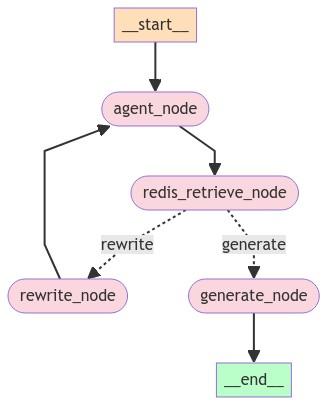

In [52]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)


# Define the nodes we will cycle between
workflow.add_node("agent_node", agent)  # agent
workflow.add_node("redis_retrieve_node", execute_tools)
workflow.add_edge("agent_node", 'redis_retrieve_node')
workflow.add_node("rewrite_node", rewrite)
workflow.add_edge("rewrite_node", "agent_node")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retrieve_node",
    check_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "rewrite_node",
        "generate": "generate_node",
    },
)

workflow.add_node("generate_node", generate)
workflow.add_edge("generate_node", END)

workflow.set_entry_point("agent_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass


In [53]:
import pprint

inputs = {
    "input":"What was the deferred revenue of Apple in 2022?",
    "messages": [
        ("user", "What was the performance of Apple revenue in 2022?"),
    ]
}
for output in graphapp.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Called agent = {'input': 'What was the deferred revenue of Apple in 2022?', 'chat_history': None, 'agent_outcome': None, 'intermediate_steps': [], 'messages': [('user', 'What was the performance of Apple revenue in 2022?')], 'filters': None, 'generation': None, 'documents': None}
RFD-DEBUG:AGENT==========
RFD-DEBUG AGENT stare={'input': 'What was the deferred revenue of Apple in 2022?', 'chat_history': None, 'agent_outcome': None, 'intermediate_steps': [], 'messages': [('user', 'What was the performance of Apple revenue in 2022?')], 'filters': None, 'generation': None, 'documents': None}
RFD-DEBUG:============
RFD-DEBUG:agent_outcome = tool='get_relevant_docs_from_redis' tool_input='Apple" and "Deferred Revenue" and "2022' log='Thought: We need to get relevant financial documents from Redis that might have information about Apple\'s deferred revenue for 2022.\n\nAction: get_relevant_docs_from_redis\n\nAction Input: "Apple" and "Deferred Revenue" and "2022'
"Output from node 'agent_node

In [54]:
import pprint

inputs2 = {
    "input":"Why colorless green ideas are furiously sleeping?",
    "messages": [
        ("user", "Why colorless green ideas are furiously sleeping?"),
    ]
}

for output in graphapp.stream(inputs2):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Called agent = {'input': 'Why colorless green ideas are furiously sleeping?', 'chat_history': None, 'agent_outcome': None, 'intermediate_steps': [], 'messages': [('user', 'Why colorless green ideas are furiously sleeping?')], 'filters': None, 'generation': None, 'documents': None}
RFD-DEBUG:AGENT==========
RFD-DEBUG AGENT stare={'input': 'Why colorless green ideas are furiously sleeping?', 'chat_history': None, 'agent_outcome': None, 'intermediate_steps': [], 'messages': [('user', 'Why colorless green ideas are furiously sleeping?')], 'filters': None, 'generation': None, 'documents': None}
RFD-DEBUG:============
RFD-DEBUG:agent_outcome = tool='get_relevant_docs_from_redis' tool_input="None (I don't have any specific input for this action since the question itself is unclear)" log="I'm not sure what to do with this question, but I'll play it safe and assume it's a trick question. Since we're dealing with financial documents, I won't attempt to answer the question myself. Instead, I'll u

AttributeError: 'tuple' object has no attribute 'content'